In [1]:
MODEL = "vgg19_bn"  # enter model name
N_EPOCHS = 32  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    5  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-3  # enter learning rate
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab


In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from tqdm import tqdm
import os
import json

torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Define Transforms
# ResNet expects 224x224 input.
# The dataset loads images as grayscale ("L").
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

# Load Dataset
dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset", mode="pose", multi_label=False, transform=transform
)

num_classes = len(dataset.idx_to_label)
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {dataset.idx_to_label}")

Total samples: 2002
Number of classes: 40
Classes: ['P0_R0', 'P10_R0', 'P15_R0', 'P15_R15', 'P15_R30', 'P15_R45', 'P15_R5', 'P25_R0', 'P30_R0', 'P30_R10', 'P30_R15', 'P30_R30', 'P30_R45', 'P30_R5', 'P30_R60', 'P35_R0', 'P40_R0', 'P45_R0', 'P45_R10', 'P45_R15', 'P45_R30', 'P45_R45', 'P45_R5', 'P45_R60', 'P50_R0', 'P55_R0', 'P5_R0', 'P60_R0', 'P60_R10', 'P60_R15', 'P60_R30', 'P60_R45', 'P60_R5', 'P60_R60', 'P65_R0', 'P70_R0', 'P75_R0', 'P80_R0', 'P85_R0', 'P90_R0']


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
)


In [6]:
# Setup Model
model = get_model(MODEL, num_classes=num_classes, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
MODEL_NAME = f"{MODEL}_pose_model_single_label"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 3.7622)
Epoch 1/32 - Train Loss: 7.9196 Acc: 0.0472 | Val Loss: 3.7622 Acc: 0.0437


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 3.1784)
Epoch 2/32 - Train Loss: 3.4251 Acc: 0.0735 | Val Loss: 3.1784 Acc: 0.1500


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 2.5482)
Epoch 3/32 - Train Loss: 3.0280 Acc: 0.1325 | Val Loss: 2.5482 Acc: 0.2250


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 4/32 - Train Loss: 2.8464 Acc: 0.1477 | Val Loss: 2.5507 Acc: 0.1938


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 5/32 - Train Loss: 2.6867 Acc: 0.1706 | Val Loss: 2.6324 Acc: 0.1562


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.9503)
Epoch 6/32 - Train Loss: 2.4915 Acc: 0.2129 | Val Loss: 1.9503 Acc: 0.3312


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 7/32 - Train Loss: 2.5735 Acc: 0.2032 | Val Loss: 2.0641 Acc: 0.3625


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 8/32 - Train Loss: 2.4504 Acc: 0.2233 | Val Loss: 2.1347 Acc: 0.3000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 9/32 - Train Loss: 2.3113 Acc: 0.2372 | Val Loss: 2.0264 Acc: 0.2687


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.9227)
Epoch 10/32 - Train Loss: 2.4634 Acc: 0.2226 | Val Loss: 1.9227 Acc: 0.2875


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.8347)
Epoch 11/32 - Train Loss: 2.3061 Acc: 0.2510 | Val Loss: 1.8347 Acc: 0.3875


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.6856)
Epoch 12/32 - Train Loss: 2.0877 Acc: 0.2892 | Val Loss: 1.6856 Acc: 0.4250


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.4646)
Epoch 13/32 - Train Loss: 1.9678 Acc: 0.3051 | Val Loss: 1.4646 Acc: 0.4625


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 14/32 - Train Loss: 1.8328 Acc: 0.3641 | Val Loss: 1.4890 Acc: 0.4562


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 15/32 - Train Loss: 2.0936 Acc: 0.3093 | Val Loss: 1.8188 Acc: 0.3625


100%|██████████| 46/46 [27:39<00:00, 36.07s/it]   


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.3371)
Epoch 16/32 - Train Loss: 2.0508 Acc: 0.3162 | Val Loss: 1.3371 Acc: 0.5563


100%|██████████| 46/46 [12:51<00:00, 16.77s/it] 


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.2315)
Epoch 17/32 - Train Loss: 1.8473 Acc: 0.3655 | Val Loss: 1.2315 Acc: 0.5312


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 18/32 - Train Loss: 1.8239 Acc: 0.3627 | Val Loss: 1.3630 Acc: 0.4750


100%|██████████| 46/46 [00:40<00:00,  1.15it/s]


Epoch 19/32 - Train Loss: 1.8928 Acc: 0.3488 | Val Loss: 1.9162 Acc: 0.2938


100%|██████████| 46/46 [00:40<00:00,  1.15it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.1591)
Epoch 20/32 - Train Loss: 1.5878 Acc: 0.4404 | Val Loss: 1.1591 Acc: 0.6000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 1.1168)
Epoch 21/32 - Train Loss: 1.6161 Acc: 0.4327 | Val Loss: 1.1168 Acc: 0.5750


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.9414)
Epoch 22/32 - Train Loss: 1.4237 Acc: 0.4750 | Val Loss: 0.9414 Acc: 0.6937


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 23/32 - Train Loss: 1.4103 Acc: 0.4861 | Val Loss: 1.2031 Acc: 0.4500


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 24/32 - Train Loss: 1.3471 Acc: 0.5014 | Val Loss: 1.1227 Acc: 0.6438


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.8792)
Epoch 25/32 - Train Loss: 1.5034 Acc: 0.4660 | Val Loss: 0.8792 Acc: 0.6562


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 26/32 - Train Loss: 1.2553 Acc: 0.5305 | Val Loss: 0.9875 Acc: 0.6000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.7685)
Epoch 27/32 - Train Loss: 1.1868 Acc: 0.5770 | Val Loss: 0.7685 Acc: 0.7125


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 28/32 - Train Loss: 1.0607 Acc: 0.6012 | Val Loss: 0.9865 Acc: 0.6562


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.7633)
Epoch 29/32 - Train Loss: 1.3328 Acc: 0.5257 | Val Loss: 0.7633 Acc: 0.6813


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.6733)
Epoch 30/32 - Train Loss: 1.0978 Acc: 0.6019 | Val Loss: 0.6733 Acc: 0.7250


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 31/32 - Train Loss: 0.9664 Acc: 0.6262 | Val Loss: 0.7249 Acc: 0.7188


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_model_single_label.pth (Val Loss: 0.6111)
Epoch 32/32 - Train Loss: 0.9686 Acc: 0.6234 | Val Loss: 0.6111 Acc: 0.7937


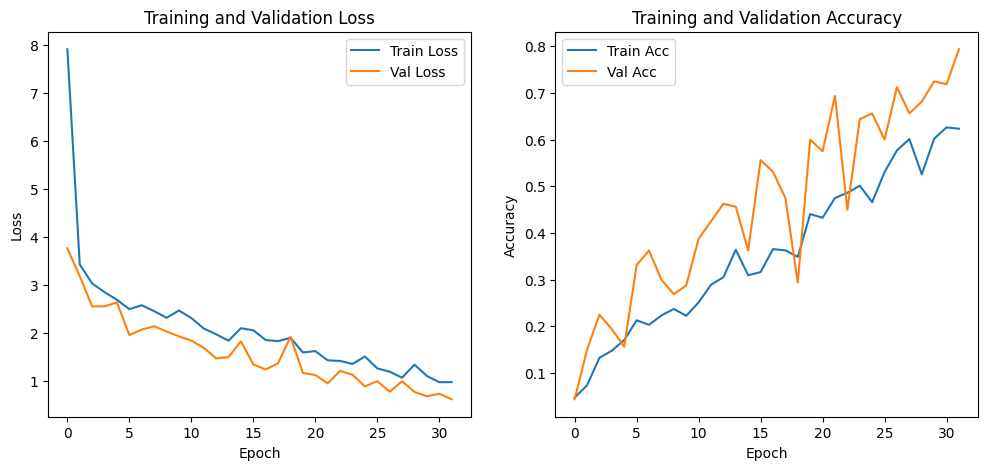

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

In [9]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_acc_loaded = checkpoint.get("val_acc")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_acc={val_acc_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Loaded checkpoint from ../model/vgg19_bn_pose_model_single_label.pth (epoch=32, val_acc=0.79375, val_loss=0.6111273646354676)
Test Set Accuracy: 0.8025


In [10]:
results = {
    "model_name": MODEL_NAME,
    "accuracy": test_accuracy,
    "metadata": {
        "N_EPOCHS": N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
    },
}

out_path = os.path.join(".eval", f"{MODEL_NAME}.json")
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to .eval/vgg19_bn_pose_model_single_label.json
